# Data and data split

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from statsmodels.stats.anova import anova_lm

data = load_data('Wage')
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


b## Data split

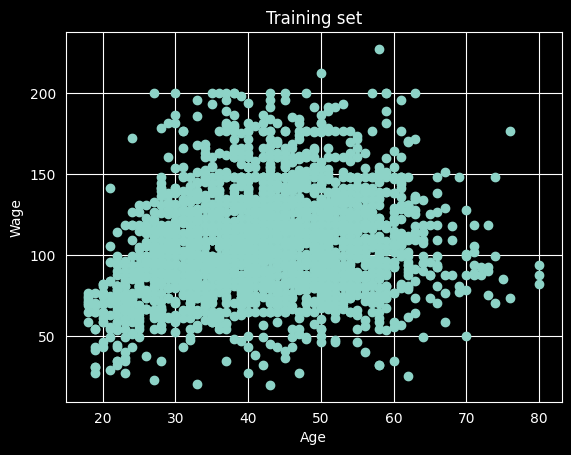

In [2]:
from sklearn.model_selection import train_test_split

data = data[data['wage'] < 250]
X, y = data[['age']], data[['wage']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(x_train, y_train)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title("Training set")
plt.show()

# Metric and plot function

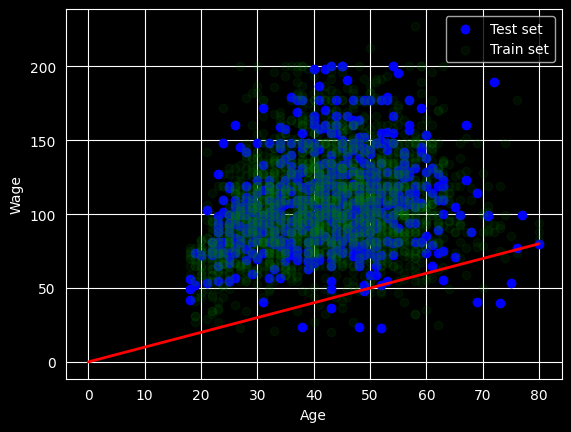

,MSE,RMSE,R2
0,0.0,0.0,1.0


In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def metric(y_hat, y_true):
    score = pd.DataFrame({
        'MSE': [mean_squared_error(y_true, y_hat)],
        'RMSE':[np.sqrt(mean_squared_error(y_true, y_hat))],
        'R2': [r2_score(y_true, y_hat)],
    })


    return score


def plot(coefs):
    global y_train, y_test

    polynomial = np.poly1d(coefs)
    x = np.linspace(0, 80, 400)
    y = polynomial(x)

    plt.plot(x, y, color='red', linewidth=2)
    plt.scatter(x_test, y_test, color='blue', label='Test set')
    plt.scatter(x_train, y_train, color='green', label='Train set', alpha=0.1)
    plt.xlabel('Age')
    plt.ylabel('Wage')
    plt.legend()
    plt.show()



plot([1,0])
metric(y_train, y_train)

# Polynomial Regression


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)), ('regressor', LinearRegression())])

pipeline

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regressor', LinearRegression())])

## Optimal degree of polynomial  - MSE Minimalization

In [5]:
import optuna
from sklearn.model_selection import cross_val_score, KFold


def object_poly(trial):
    global x_train, x_test
    degree = trial.suggest_int('poly__degree', 1, 20)
    pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('regressor', LinearRegression(fit_intercept=False))])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(object_poly, n_trials=20, show_progress_bar=True)
print(study.best_params)


pipeline.set_params(**study.best_params)
pipeline.fit(x_train, y_train)

poly_score = metric(pipeline.predict(x_test), y_test)
poly_score

[I 2025-12-15 10:06:19,746] A new study created in memory with name: no-name-535c3627-1d82-406d-a9bf-07c7fe47bd90


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 10:06:19,803] Trial 0 finished with value: -917.8307474427035 and parameters: {'poly__degree': 7}. Best is trial 0 with value: -917.8307474427035.
[I 2025-12-15 10:06:19,875] Trial 1 finished with value: -917.3731352965206 and parameters: {'poly__degree': 8}. Best is trial 1 with value: -917.3731352965206.
[I 2025-12-15 10:06:19,960] Trial 2 finished with value: -4495.599667142682 and parameters: {'poly__degree': 18}. Best is trial 1 with value: -917.3731352965206.
[I 2025-12-15 10:06:20,029] Trial 3 finished with value: -915.023710683121 and parameters: {'poly__degree': 3}. Best is trial 3 with value: -915.023710683121.
[I 2025-12-15 10:06:20,068] Trial 4 finished with value: -2485.3194565280523 and parameters: {'poly__degree': 15}. Best is trial 3 with value: -915.023710683121.
[I 2025-12-15 10:06:20,103] Trial 5 finished with value: -916.0687063968101 and parameters: {'poly__degree': 5}. Best is trial 3 with value: -915.023710683121.
[I 2025-12-15 10:06:20,143] Trial 6

,MSE,RMSE,R2
0,908.456193,30.140607,0.094868


## Ploting

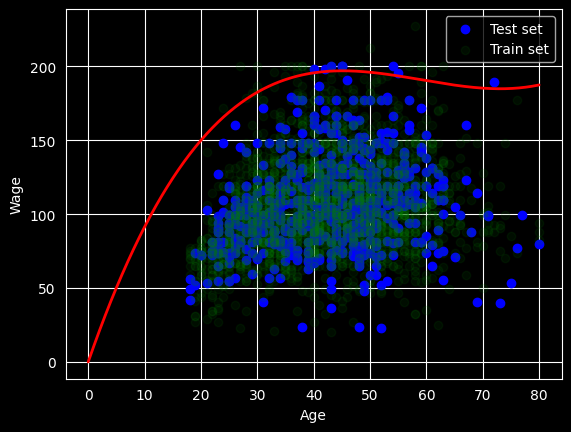

[ 1.11111567e-03 -1.97048428e-01  1.09966926e+01  0.00000000e+00]


In [6]:
linear_model = pipeline.named_steps['regressor']
coefficients = linear_model.coef_.ravel()[::-1]

plot(coefficients)
print(coefficients)

### ANOVA


In [7]:
from scipy.stats import f

def calculate_rss(model, X, y):
    y_pred = model.predict(X)
    return np.sum((y - y_pred)**2, axis=0)






# We need the RSS for the d=1 (linear) model to start
poly_d_minus_1 = PolynomialFeatures(degree=1, include_bias=False)
X_d_minus_1 = poly_d_minus_1.fit_transform(x_train)
model_d_minus_1 = LinearRegression().fit(X_d_minus_1, y_train)
RSS_d_minus_1 = calculate_rss(model_d_minus_1, X_d_minus_1, y_train)


#Store data for DF
Degrees = []
F_stats = []
Pvalues = []

import statsmodels.regression.linear_model as st

N_total = len(x_train)
max_degree = 10


models = []
for d in range(1, max_degree + 1):
    poly_d = PolynomialFeatures(degree=d, include_bias=False)
    X_d = poly_d.fit_transform(x_train)
    model_d = LinearRegression().fit(X_d, y_train)

    model_st = st.OLS(y_train, X_d)
    result = model_st.fit()
    models.append(result)

    RSS_d = calculate_rss(model_d, X_d, y_train)

    df_d_minus_1 = N_total - d
    df_d = N_total - (d + 1)
    df_num = 1
    df_den = df_d

    # Calculate the F-statistic
    F_statistic = ((RSS_d_minus_1 - RSS_d) / df_num) / (RSS_d / df_den)

    # Calculate the p-value using Scipy's survival function (sf)
    p_value = f.sf(F_statistic, df_num, df_den)

    RSS_d_minus_1 = RSS_d

    Degrees.append(d)
    F_stats.append(float(F_statistic.iloc[0]))
    Pvalues.append(p_value[0])


result = pd.DataFrame({
    "Polynomial Degrees": Degrees,
    "F - statistic": F_stats,
    'p-value': Pvalues,
})

result

,Polynomial Degrees,F - statistic,p-value
0,1,0.000000,1.000000e+00
1,2,153.113245,4.147682e-34
2,3,22.536035,2.187349e-06
3,4,3.178943,7.472307e-02
4,5,0.157266,6.917228e-01
5,6,0.956693,3.281232e-01
6,7,0.148946,6.995798e-01
7,8,-0.253140,1.000000e+00
8,9,-0.027325,1.000000e+00
9,10,-0.115514,1.000000e+00


In [8]:
anova_lm(*models)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2335.0,3.410622e+06,0.0,NaN,NaN,NaN
1,2334.0,2.147714e+06,1.0,1.262908e+06,1383.932049,2.910901e-238
2,2333.0,2.144378e+06,1.0,3.336251e+03,3.655962,5.599124e-02
3,2332.0,2.133955e+06,1.0,1.042268e+04,11.421480,7.379444e-04
4,2331.0,2.124741e+06,1.0,9.214580e+03,10.097608,1.504056e-03
5,2330.0,2.123541e+06,1.0,1.199576e+03,1.314530,2.516938e-01
6,2329.0,2.123384e+06,1.0,1.565643e+02,0.171568,6.787604e-01
7,2329.0,2.123362e+06,-0.0,2.196170e+01,-inf,NaN
8,2329.0,2.123391e+06,-0.0,-2.854057e+01,inf,NaN
9,2329.0,2.125331e+06,-0.0,-1.939779e+03,inf,NaN


## Anova interpretation and model test

In [14]:
pipeline.set_params(poly__degree=3)
pipeline.fit(x_train, y_train)

poly_score = metric(pipeline.predict(x_test), y_test)
poly_score

,MSE,RMSE,R2
0,908.456193,30.140607,0.094868


### Plot

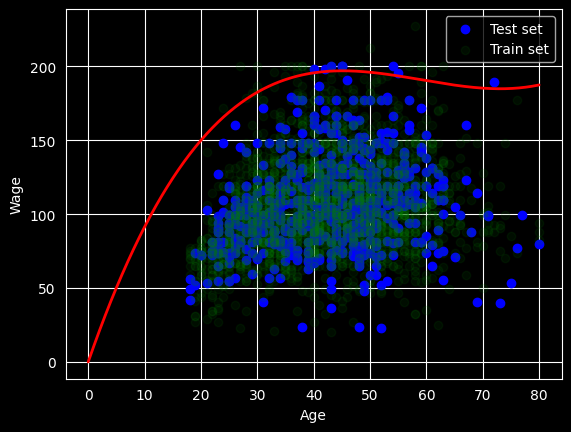

[ 1.11111567e-03 -1.97048428e-01  1.09966926e+01  0.00000000e+00]


In [15]:
linear_model = pipeline.named_steps['regressor']
coefficients = linear_model.coef_.ravel()[::-1]

plot(coefficients)
print(coefficients)

# Step Function

In [16]:
def create_step_features(X, step, return_knots=False):
    X_features = []
    xmin = x_train.min().iloc[0]
    xmax = x_train.max().iloc[0]
    knots = np.arange(xmin,xmax , step=step)
    # print(f"{knots=}")

    # Segment 1: x < knot[0]
    X_features.append((X < knots[0]).astype(int))

    # Intermediate Segments
    for i in range(len(knots) - 1):
        feature = (X >= knots[i]) & (X < knots[i+1])
        X_features.append(feature.astype(int))

    # Last Segment: x >= knot[-1]
    X_features.append((X >= knots[-1]).astype(int))

    # Combine features into a single array
    if return_knots:
        knots = np.insert(knots, 0, 0)
        knots = np.append(knots, 100)
        return np.hstack(X_features), knots

    return np.hstack(X_features)

x_s = create_step_features(x_train, 10)
x_s

def objective_step(trial):
   step = trial.suggest_int('step', 2, 20)

   X_s = create_step_features(x_s, step)

   model = LinearRegression(fit_intercept=False)
   score = cross_val_score(model, X_s, y_train, cv=5, scoring='neg_mean_squared_error')

   return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective_step, n_trials=20, show_progress_bar=True)
print(f'{study.best_params=}')

X_step = create_step_features(x_train, study.best_params['step'])
model = LinearRegression(fit_intercept=False)

model.fit(X_step, y_train)
step_preds = model.predict(create_step_features(x_test, study.best_params['step']))

metric(step_preds, y_test)

[I 2025-12-15 10:08:08,689] A new study created in memory with name: no-name-1f8e1d3d-124c-4a0f-b8a9-ac572ca95f8c


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 10:08:08,832] Trial 0 finished with value: -1025.791832550289 and parameters: {'step': 6}. Best is trial 0 with value: -1025.791832550289.
[I 2025-12-15 10:08:09,164] Trial 1 finished with value: -1025.7675610561857 and parameters: {'step': 4}. Best is trial 1 with value: -1025.7675610561857.
[I 2025-12-15 10:08:09,276] Trial 2 finished with value: -1025.7917921436324 and parameters: {'step': 18}. Best is trial 1 with value: -1025.7675610561857.
[I 2025-12-15 10:08:09,372] Trial 3 finished with value: -1025.7917921436324 and parameters: {'step': 14}. Best is trial 1 with value: -1025.7675610561857.
[I 2025-12-15 10:08:09,443] Trial 4 finished with value: -1025.791832550289 and parameters: {'step': 11}. Best is trial 1 with value: -1025.7675610561857.
[I 2025-12-15 10:08:09,527] Trial 5 finished with value: -1025.7917921436324 and parameters: {'step': 18}. Best is trial 1 with value: -1025.7675610561857.
[I 2025-12-15 10:08:09,578] Trial 6 finished with value: -1025.791792

,MSE,RMSE,R2
0,913.993287,30.232322,0.089351


# Plotting

[  0  18  22  26  30  34  38  42  46  50  54  58  62  66  70  74  78 100]
[ 88.24446161 109.12132943  94.51521868 104.64039202 108.9477557
 112.03611501 110.74680952 111.03701487 114.62591756 114.7248002
 113.26017348 108.85350022 103.96083303  97.28826781  78.03877251
  66.87226802   0.        ]


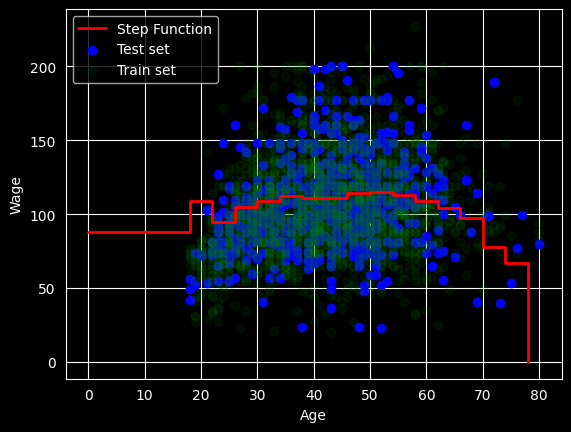

In [17]:
_ , knots = create_step_features(x_train, study.best_params['step'], return_knots=True)
coefficients = (model.coef_.ravel()[::-1])
print(knots)
print(coefficients)
plt.step(knots[:-1], coefficients, where='post', label='Step Function', color='red', linewidth=2)
plt.scatter(x_test, y_test, color='blue', label='Test set')
plt.scatter(x_train, y_train, color='green', label='Train set', alpha=0.1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()